In [2]:
#libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast

from scipy.spatial.distance import euclidean, cityblock
from sklearn.base import clone
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD

import plotly.offline as py
import plotly.graph_objects as go
import networkx as nx

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


Activities to do:

1. Sentiment Classifier
2. Topic Modeling

Things to do:

1. Clean dataset
2. Clustering? (Need to determine if democrats or republicans share somewhat the same sentiments)
3. Writeup on the newly generated clusters
4. Topic Modeling



Sample Cleaning: https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed

Sample Cleaning + Pipeline of Vectorizer: https://medium.com/vickdata/detecting-hate-speech-in-tweets-natural-language-processing-in-python-for-beginners-4e591952223

Textblob polarity: https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082

# Scraping

Writep of Scraping and twint (insert Nisarg's code in this part)

# Data Importation

The group has decided to separate the tweets into Democrats and Republicans to get an overall feel of how the US Elections are divided amongst the two parties, rather than a unified body.

In [ ]:
rep = pd.read_csv('republican.csv').dropna(subset=['tweet'])
print(rep.shape)
rep[['id','user_id','username','date','tweet']].sample(5)

(32344, 36)


,id,user_id,username,date,tweet
20306,1320478195838341120,1.310967e+18,burroughs_cd,2020-10-25,@CassandraRules I get crap from both but Trump...
14259,1320514725713743872,1.762773e+08,halofreak223,2020-10-25,Trump is out of his fucking mind calling COVID...
6927,1320488396926701568,1.187809e+09,davidgmoorejr,2020-10-25,"@kirstiealley, who shared her support for Trum..."
5029,1320473230654754816,1.241142e+18,jason15809039,2020-10-25,@GOPChairwoman @realDonaldTrump It's easy to s...
2909,1320493143142400002,1.162953e+08,brebutterfly,2020-10-25,@WhiteHouse @realDonaldTrump @FLOTUS Effect......


In [ ]:
dem = pd.read_csv('democrat.csv').dropna(subset=['tweet'])
print(dem.shape)
dem[['id','user_id','username','date','tweet']].sample(5)

(22808, 36)


,id,user_id,username,date,tweet
16427,1320499069903609857,1308152888569597961,bucknut29,2020-10-25,"@BillisKing I would have replied “oh no, after..."
11912,1320434491157061635,1050196639816671233,gladysrbates142,2020-10-25,Trump is not a Commander and Chief He has sur...
18767,1320512433165774848,1300503149128511488,voyagerwayward,2020-10-25,@JoeBiden What’s with these old videos from a ...
15707,1320501721785913344,82662721,huzzahmpls,2020-10-25,"6. Likewise there is a total lack of ""Normie D..."
19526,1320511213998993408,13673822,noirista,2020-10-25,What that looks like this year is electing: @...


# Data Preprocessing

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
from nltk import word_tokenize 
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_content(text):
    """Removes unnecessary content from the text"""
    try:
        text = re.sub(r"http\S+", "", text) #remove urls
        text=re.sub(r'\S+\.com\S+','',text) #remove urls
        text=re.sub(r'\@\w+','',text) #remove mentions
        text =re.sub(r'\#\w+','',text) #remove hashtags
    except:
        pass
    return text
def process_text(text, stem=False): #clean text
    """Retains text characters and tokenizes them"""
    text=remove_content(text)
    text = re.sub('[^A-Za-z]', ' ', text.lower()) #remove non-alphabets
    tokenized_text = word_tokenize(text) #tokenize
    clean_text = [
         word for word in tokenized_text
         if word not in stop_words
    ]
    if stem:
        clean_text=[stemmer.stem(word) for word in clean_text]
    return ' '.join(clean_text)

In [ ]:
dem['clean_tweet'] = dem['tweet'].apply(lambda x: remove_content(x))
dem['tokens'] = dem['clean_tweet'].apply(lambda x: process_text(x))
rep['clean_tweet'] = rep['tweet'].apply(lambda x: remove_content(x))
rep['tokens'] = rep['clean_tweet'].apply(lambda x: process_text(x))

# Do we still need to include the clustering? Or directly skip towards Sentiment analysis instead huhuhu because of computational efficiency, the codes really take too long to run huhu

# Clustering

In [ ]:
vec = TfidfVectorizer(smooth_idf=False, token_pattern=r'\b[a-z]+\b',
                             min_df=0.005,stop_words='english')

vec.fit(dem['tokens'])

bag_of_words = vec.transform(dem['tokens'])

dem_bow_df = pd.DataFrame.sparse.from_spmatrix(
        bag_of_words, columns=vec.get_feature_names())
    
dem_bow_df

,actually,administration,ago,agree,america,american,americans,amp,anti,ask,attending,away,bad,ballot,believe,bernie,best,better,biden,big,black,blue,bring,business,called,campaign,candidate,care,change,check,children,china,come,coming,control,corrupt,corruption,country,court,covid,...,times,today,true,trump,truth,try,trying,turn,u,understand,usa,use,video,videos,virus,vote,voted,voter,voters,votes,voting,w,wait,want,wants,watch,way,week,white,win,wins,women,work,working,world,wrong,yeah,year,years,yes
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.432613,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.315093,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.354166,0.0,0.0,0.0,0.378565,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.416772,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.386048,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.711418,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.436803,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.442888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22803,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.196367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22804,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.196367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22805,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.196367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22806,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,

In [ ]:
vec = TfidfVectorizer(smooth_idf=False, token_pattern=r'\b[a-z]+\b',
                             min_df=0.005,stop_words='english')

vec.fit(rep['tokens'])

bag_of_words = vec.transform(rep['tokens'])

rep_bow_df = pd.DataFrame.sparse.from_spmatrix(
        bag_of_words, columns=vec.get_feature_names())
    
rep_bow_df

,actually,administration,agree,america,american,americans,amp,anti,ass,away,bad,barrett,believe,best,better,biden,big,black,blue,business,called,campaign,candidate,car,care,cases,cause,change,children,china,come,coming,conservative,control,corrupt,country,court,covid,day,days,...,try,trying,twitter,u,understand,united,usa,use,using,video,virus,vote,voted,voter,voters,votes,voting,w,wait,want,wants,watch,watching,way,wearing,went,white,win,wins,woman,women,work,world,wow,wrong,yeah,year,years,yes,york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.343895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.958194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.286120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.515337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.331345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32339,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32340,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32341,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.681018,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32342,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.526847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.532902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.

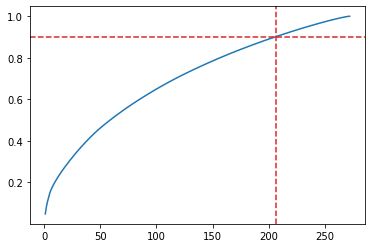

In [ ]:
dem_lsa = TruncatedSVD(n_components=len(dem_bow_df.columns)-1, 
                       random_state=1337)

dem_lsa.fit(dem_bow_df.to_numpy())

dem_exp_var = dem_lsa.explained_variance_ratio_.cumsum()

dem_lim = np.min(np.arange(1, len(dem_bow_df.columns))[dem_exp_var >= 0.90])

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(1, len(dem_bow_df.columns)), dem_lsa.explained_variance_ratio_.cumsum())

# Plot threshold
ax.axvline(dem_lim, linestyle='--', color='tab:red')
ax.axhline(0.9, linestyle='--', color='tab:red')

In [ ]:
print(dem_lim)

206


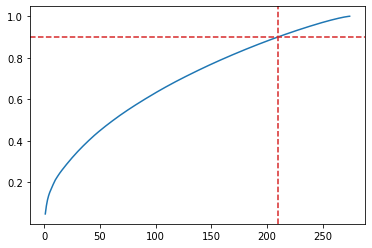

In [ ]:
rep_lsa = TruncatedSVD(n_components=len(rep_bow_df.columns)-1, 
                       random_state=1337)

rep_lsa.fit(rep_bow_df.to_numpy())

rep_exp_var = rep_lsa.explained_variance_ratio_.cumsum()

rep_lim = np.min(np.arange(1, len(rep_bow_df.columns))[rep_exp_var >= 0.90])

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(1, len(rep_bow_df.columns)), rep_lsa.explained_variance_ratio_.cumsum())

# Plot threshold
ax.axvline(rep_lim, linestyle='--', color='tab:red')
ax.axhline(0.9, linestyle='--', color='tab:red')

In [ ]:
print(rep_lim)

210


In [ ]:
def pooled_within_ssd(X, y, centroids, dist):
    return sum(dist(xx, centroids[yy])**2/(2 * (y == yy).sum())
               for xx, yy in zip(X, y.astype(int)))

def gap_statistic(X, y, centroids, dist, b, clusterer, random_state=None):
    rng = np.random.default_rng(random_state)
    W_k = np.log(pooled_within_ssd(X, y, centroids, dist))
    gs = np.array([])
    for i in range(b):
        X_hat = rng.uniform(low =X.min( 0), high =X.max( 0), size =X.shape)
        y_pred = clusterer.fit_predict(X_hat)
        centroids_pred = clusterer.cluster_centers_
        W_ik = np.log(pooled_within_ssd(X_hat, y_pred, centroids_pred, dist))
        gs = np.append(gs, (W_ik - W_k))
    return gs.mean(), gs.std()

def cluster_range(X, clusterer, k_start, k_stop, actual=None):
    ys = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    for k in range(k_start, k_stop+1):
        clusterer_k = clone(clusterer)
        clusterer_k.set_params(n_clusters=k)
        y = clusterer_k.fit_predict(X)
        ys += [y]
        inertias += [clusterer_k.inertia_]
        chs += [calinski_harabasz_score(X, y)]
        scs += [silhouette_score(X, y)]
        
        if actual is not None:
            ps += [purity(actual, y)]
            amis += [adjusted_mutual_info_score(actual, y)]
            ars += [adjusted_rand_score(actual, y)]
            
        gs = gap_statistic(X, y, clusterer_k.cluster_centers_, 
                                 euclidean, 5, 
                                 clone(clusterer).set_params(n_clusters=k), 
                                 random_state=1337)
        gss.append(gs[0])
        gssds.append(gs[1])
    res = {'ys':ys, 'inertias':inertias, 'chs':chs, 'gss':gss, 'gssds':gssds,
          'scs':scs}
    if actual is not None:
        res['ps'] = ps
        res['amis'] = amis
        res['ars'] = ars
    return res

def plot_internal(inertias, chs, scs, gss, gssds):
    fig, ax = plt.subplots()
    ks = np.arange(2, len(inertias)+2)
    ax.plot(ks, inertias, '-o', label='SSE')
    ax.plot(ks, chs, '-ro', label='CH')
    ax.set_xlabel('$k$')
    ax.set_ylabel('SSE/CH')
    lines, labels = ax.get_legend_handles_labels()
    ax2 = ax.twinx()
    ax2.errorbar(ks, gss, gssds, fmt='-go', label='Gap statistic')
    ax2.plot(ks, scs, '-ko', label='Silhouette coefficient')
    ax2.set_ylabel('Gap statistic/Silhouette')
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines+lines2, labels+labels2)
    return ax

def plot_clusters(X, ys):
    k_max = len(ys) + 1
    k_mid = k_max//2 + 2
    fig, ax = plt.subplots(2, k_max//2, dpi=150, sharex=True, sharey=True, 
                           figsize=(7,4), subplot_kw=dict(aspect='equal'),
                           gridspec_kw=dict(wspace=0.01))
    for k,y in zip(range(2, k_max+1), ys):
        if k < k_mid:
            ax[0][k%k_mid-2].scatter(X[:, 0], X[:, 1], c=y, s=1, alpha=0.8)
            ax[0][k%k_mid-2].set_title('$k=%d$'%k)
        else:
            ax[1][k%k_mid].scatter(X[:, 0], X[:, 1], c=y, s=1, alpha=0.8)
            ax[1][k%k_mid].set_title('$k=%d$'%k)
    return ax

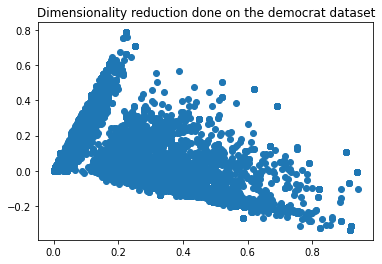

In [ ]:
dem_bowtrans = dem_lsa.transform(dem_bow_df.to_numpy())

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title('Dimensionality reduction done on the democrat dataset')
ax.plot(dem_bowtrans[:, 0], dem_bowtrans[:, 1], 'o')

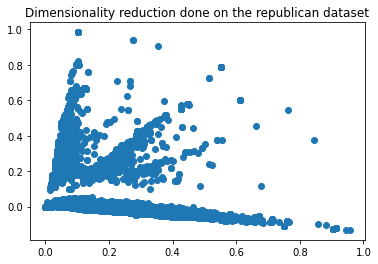

In [ ]:
rep_bowtrans = rep_lsa.transform(rep_bow_df.to_numpy())

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title('Dimensionality reduction done on the republican dataset')
ax.plot(rep_bowtrans[:, 0], rep_bowtrans[:, 1], 'o')

In [ ]:
dem_res_txts = cluster_range(dem_bowtrans[:, :dem_lim], KMeans(random_state=1337), 2, 11)
rep_res_txts = cluster_range(rep_bowtrans[:, :rep_lim], KMeans(random_state=1337), 2, 11)

In [ ]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k, random_state=1337).fit(dem_bowtrans[:, :dem_lim])
    labels = kmeans.labels_
    sil.append(silhouette_score(dem_bowtrans[:, :dem_lim], labels, metric = 'euclidean'))

In [ ]:
#optimal democrat clusters
sil

[0.08367532642277298,
 0.0734448999691464,
 0.07600835791172875,
 0.07330686954542663,
 0.07572318622533429,
 0.07903745617902677,
 0.07990013923870462,
 0.08071593641300831,
 0.07171050170841536]

In [ ]:
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k, random_state=1337).fit(rep_bowtrans[:, :rep_lim])
    labels = kmeans.labels_
    sil.append(silhouette_score(rep_bowtrans[:, :rep_lim], labels, metric = 'euclidean'))

In [ ]:
#optimal republican clusters
sil

[0.08237169346259134,
 0.08768908734197726,
 0.08105342704034395,
 0.09043869679938266,
 0.08824206056315806,
 0.09300243458521125,
 0.09894542200953602,
 0.10250950940415511,
 0.10541949596422082]

# Optimal Clusters

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63623bf198>,
      dtype=object)

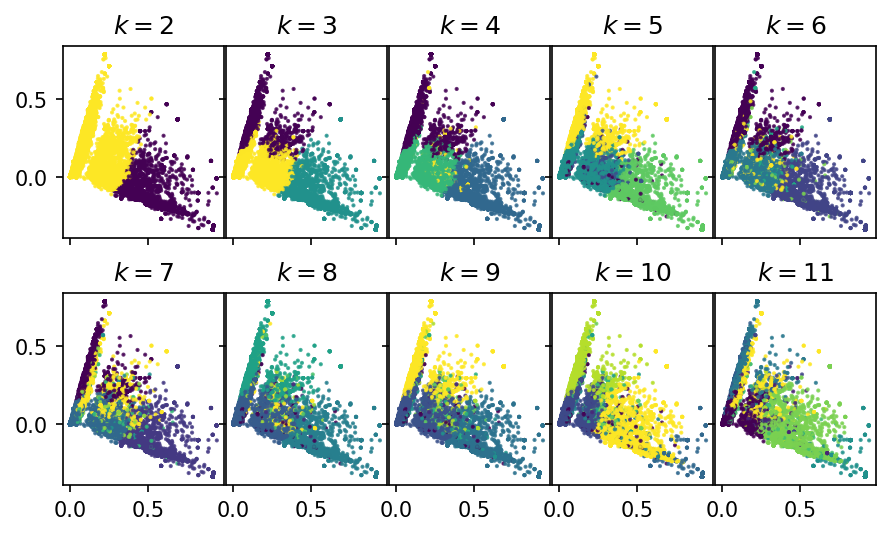

In [ ]:
plot_clusters(dem_bowtrans, dem_res_txts['ys'])

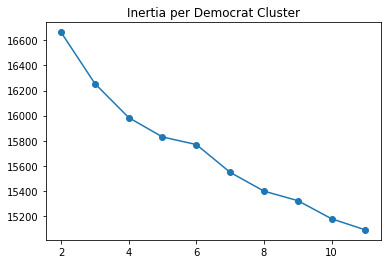

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title('Inertia per Democrat Cluster')
ax.plot(range(2, 12), dem_res_txts['inertias'], 'o-')

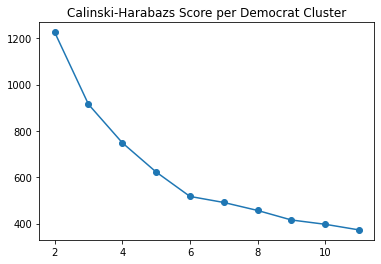

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title('Calinski-Harabazs Score per Democrat Cluster')
ax.plot(range(2, 12), dem_res_txts['chs'], 'o-')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f635f4eee10>,
      dtype=object)

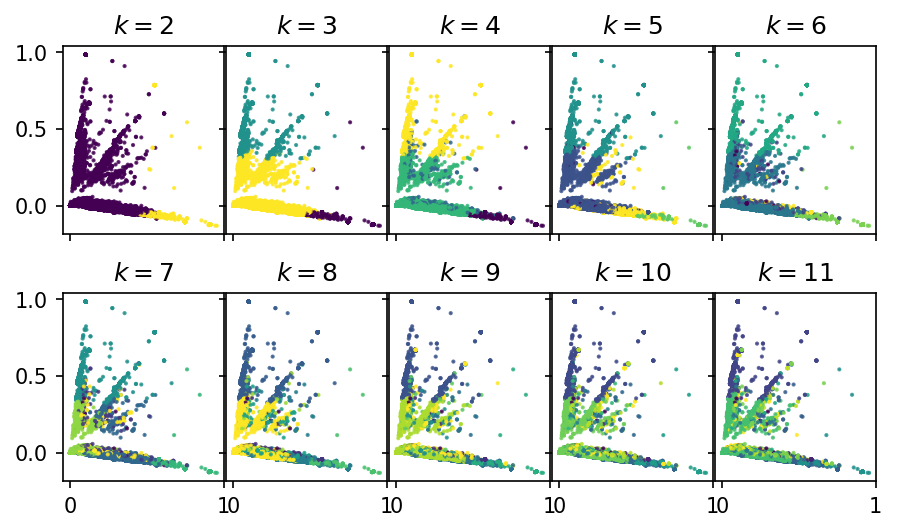

In [ ]:
plot_clusters(rep_bowtrans, rep_res_txts['ys'])

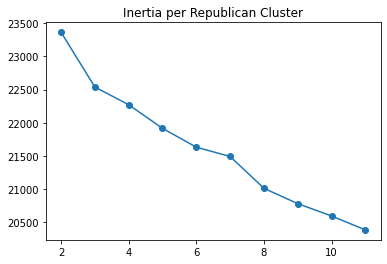

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title('Inertia per Republican Cluster')
ax.plot(range(2, 12), rep_res_txts['inertias'], 'o-')

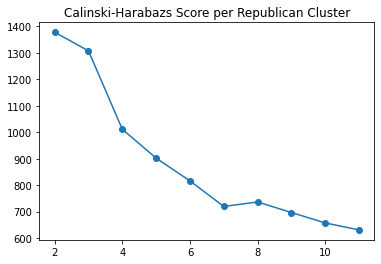

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title('Calinski-Harabazs Score per Republican Cluster')
ax.plot(range(2, 12), rep_res_txts['chs'], 'o-')

# Clustering-based Sentiment Classification

In [ ]:
n_clusters = 4
dem_kmeans = KMeans(n_clusters=n_clusters, random_state=1337)
rep_kmeans = KMeans(n_clusters=n_clusters, random_state=1337)

y_dem_predict = dem_kmeans.fit_predict(dem_bowtrans[:, :dem_lim])
y_rep_predict = rep_kmeans.fit_predict(rep_bowtrans[:, :rep_lim])

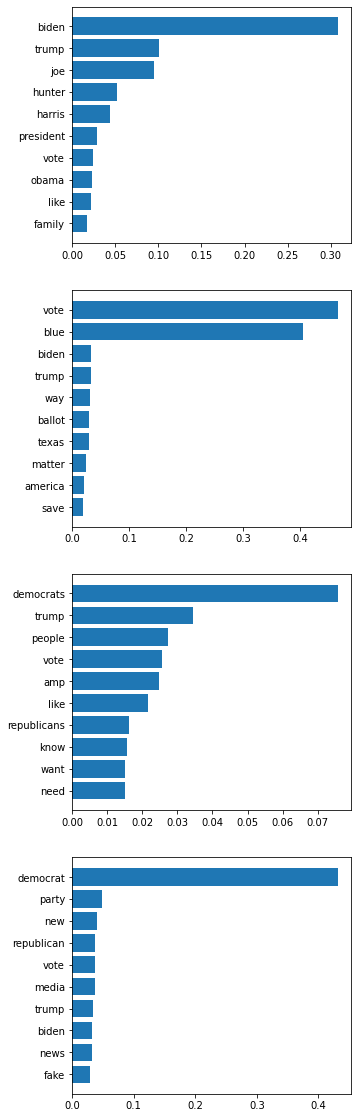

In [ ]:
#democrat clusters
dem_weights = np.dot(dem_kmeans.cluster_centers_, dem_lsa.components_[:dem_lim, :])

fig, axes = plt.subplots(n_clusters, 1, figsize=(5, 5*n_clusters))

for i, x in enumerate(dem_weights):
    indices = np.argsort(x)[-10::]
    words = [dem_bow_df.columns[q] for q in indices]
    axes[i].barh(words, x[indices])

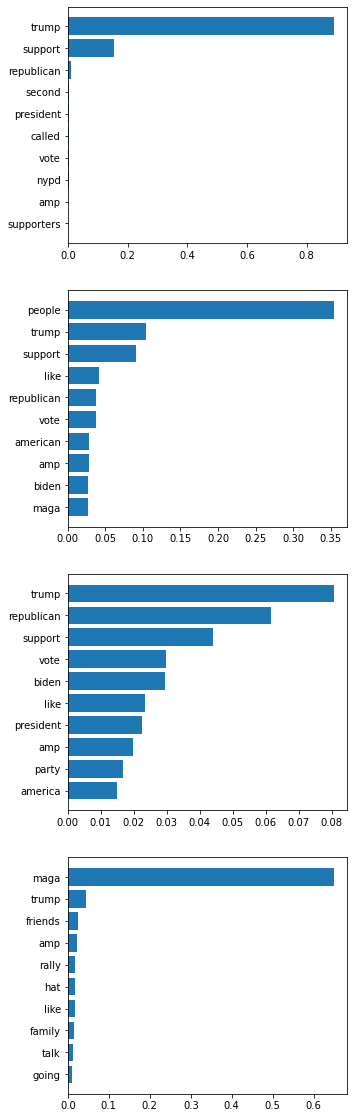

In [ ]:
#republican clusters
rep_weights = np.dot(rep_kmeans.cluster_centers_, rep_lsa.components_[:rep_lim, :])

fig, axes = plt.subplots(n_clusters, 1, figsize=(5, 5*n_clusters))

for i, x in enumerate(rep_weights):
    indices = np.argsort(x)[-10::]
    words = [rep_bow_df.columns[q] for q in indices]
    axes[i].barh(words, x[indices])

In [ ]:
dem['cluster'] = y_dem_predict
rep['cluster'] = y_rep_predict

# Sentiment Analysis

After processing the data to be ready for analysis, the team decided to generate initial EDA for both the Democrat and Republican Datasets.

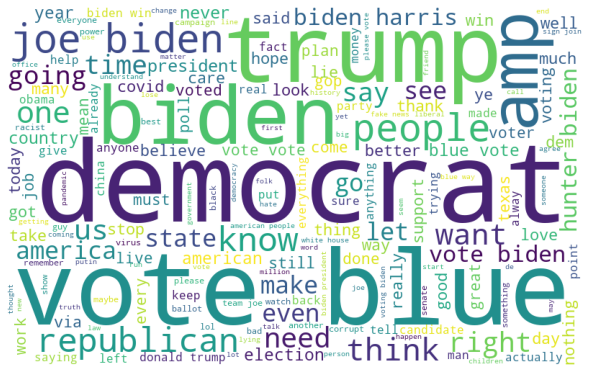

In [ ]:
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
import matplotlib.pyplot as plt

dem_cloud=' '.join(dem['tokens'].tolist())
dem_wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(dem_cloud)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(dem_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

### Figure 1 Democrat Wordcloud

From the wordcloud, we can see that Democrat tweets mainly compose of Joe Biden, as well as "blue". What's more surprising is that "Trump" and "republican" are also included in the wordcloud, possibly hinting at taking a jab at the opposition via tweets.

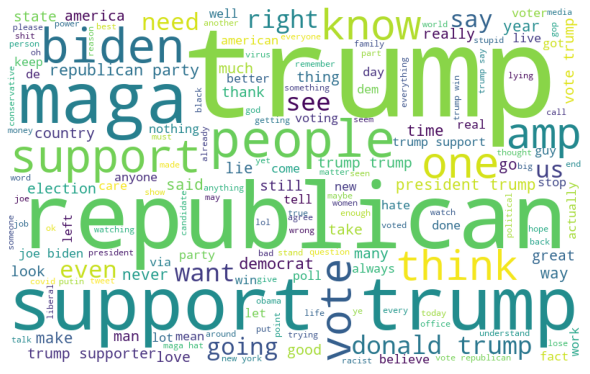

In [ ]:
rep_cloud=' '.join(rep['tokens'].tolist())
rep_wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(rep_cloud)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(rep_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

### Figure 2 Republican Wordcloud

The Republican Wordcloud, on the other hand, focuses mainly on Trump support all around, with the word "Democrat" being a small piece of the figure shown above.

In [ ]:
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
def plot_topn(sentences, ngram_range=(1,3), top=20,firstword=''):
    c=CountVectorizer(ngram_range=ngram_range)
    X=c.fit_transform(sentences)
    words=pd.DataFrame(X.sum(axis=0),columns=c.get_feature_names()).T.sort_values(0,ascending=False).reset_index()
    res=words[words['index'].apply(lambda x: firstword in x)].head(top)
    pl=px.bar(res, x='index',y=0)
    pl.update_layout(yaxis_title='count',xaxis_title='Phrases')
    pl.show()

In [ ]:
print(plot_topn(dem.tokens, ngram_range=(1,1)))
print(plot_topn(dem.tokens, ngram_range=(2,2)))
print(plot_topn(dem.tokens, ngram_range=(3,3)))

None


None


None


### Figure 3 Unigrams to Trigrams of the most common words for the democrat tweets

Since the group collected the tweets nearing the actual casting of votes, the most common words coming from the Democrats were focused on voting

In [ ]:
print(plot_topn(rep.tokens, ngram_range=(1,1)))
print(plot_topn(rep.tokens, ngram_range=(2,2)))
print(plot_topn(rep.tokens, ngram_range=(3,3)))

None


None


None


### Figure 4 Unigrams to Trigrams of the most common words for the republican tweets

As for the Republicans, it can be seen that they still focus on supporting Trump, as well as their slogan of making America great. However, negative words are also seen such as "loser loser loser".

In [ ]:
import itertools
import ast
from collections import Counter
# Counter(list(itertools.chain(*df.hashtags.apply(lambda x:ast.literal_eval(x))))).most_common(20)
print(plot_topn(list(itertools.chain(*dem.dropna(subset=['hashtags'])
                                         .hashtags.apply(
                                             lambda x:ast.literal_eval(x))))))
print(plot_topn(list(itertools.chain(*rep.dropna(subset=['hashtags'])
                                         .hashtags.apply(
                                             lambda x:ast.literal_eval(x))))))

None


None


### Figure 5 Most common hashtags for the Democrats and the Republicans

Aside from the most common words used by both parties, the Democrats and the Republicans continue to show support in their hashtags of tweets. They also both show discontentment for the opposing parties. Tweets such as #VoteHimOut from the Democrats and #StopTheSteal from the Republicans show that they are not eager to give away their chances of winning the election anytime soon.|

In [ ]:
from textblob import TextBlob
dem['sentiment']=dem['tokens'].apply(lambda x:TextBlob(x).sentiment[0])
dem['subject']=dem['tokens'].apply(lambda x: TextBlob(x).sentiment[1])
dem['polarity']=dem['sentiment'].apply(lambda x: 'pos' if x>=0 else 'neg')

In [ ]:
rep['sentiment']=rep['tokens'].apply(lambda x:TextBlob(x).sentiment[0])
rep['subject']=rep['tokens'].apply(lambda x: TextBlob(x).sentiment[1])
rep['polarity']=rep['sentiment'].apply(lambda x: 'pos' if x>=0 else 'neg')

In [ ]:
dem['party'] = 'democrat'
rep['party'] = 'republican'

dem.to_csv('dem_expanded.csv', index=False)
rep.to_csv('rep_expanded.csv', index=False)

In [ ]:
dem_fig=px.histogram(dem[dem['subject']>0.5], x='polarity', color='polarity')
dem_fig.show()

### Figure 6 Democrat Sentiment

Based from the figure above, Democrats pose a positive sentiment, with the negative probably being thrown for the opposing party

In [ ]:
rep_fig=px.histogram(rep[rep['subject']>0.5], x='polarity', color='polarity')
rep_fig.show()

### Figure 7 Republican Sentiment

On the other hand, Republicans do seem to almost have the same positive and negative sentiments. This might imply that apart from showing support for the Republican party, they also show as much negative sentiment towards the opposing Republicans. What an active user base.

# Topic Modeling

In order to determine a more granular description of the words being thrown by both parties just a few weeks before the elections, the group has decided to utilize topic modeling to determine what main ideas are present among the tweets of both the Democrats and the Republicans.

In [ ]:
dem_pos = dem[dem['polarity']=='pos'].tokens
dem_neg = dem[dem['polarity']=='neg'].tokens
rep_pos = rep[rep['polarity']=='pos'].tokens
rep_neg = rep[rep['polarity']=='neg'].tokens

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemmatizer.lemmatize(word) for word in punc_free.split())
    return normalized

In [ ]:
dem_pos_doc_clean = [clean(file).split() for file in dem_pos]
dem_neg_doc_clean = [clean(file).split() for file in dem_neg]
rep_pos_doc_clean = [clean(file).split() for file in rep_pos]
rep_neg_doc_clean = [clean(file).split() for file in rep_neg]

In [ ]:
import gensim
from gensim import corpora

dem_pos_dictionary = corpora.Dictionary(dem_pos_doc_clean)
dem_neg_dictionary = corpora.Dictionary(dem_neg_doc_clean)
rep_pos_dictionary = corpora.Dictionary(rep_pos_doc_clean)
rep_neg_dictionary = corpora.Dictionary(rep_neg_doc_clean)

dem_pos_doc_term_matrix = [dem_pos_dictionary.doc2bow(tweet) for tweet in dem_pos_doc_clean]
dem_neg_doc_term_matrix = [dem_neg_dictionary.doc2bow(tweet) for tweet in dem_neg_doc_clean]
rep_pos_doc_term_matrix = [rep_pos_dictionary.doc2bow(tweet) for tweet in rep_pos_doc_clean]
rep_neg_doc_term_matrix = [rep_neg_dictionary.doc2bow(tweet) for tweet in rep_neg_doc_clean]



print(dem_pos_dictionary)
print(dem_neg_dictionary)
print(rep_pos_dictionary)
print(rep_neg_dictionary)


Dictionary(15008 unique tokens: ['across', 'bring', 'capacity', 'chief', 'confront']...)
Dictionary(8256 unique tokens: ['abandon', 'alone', 'challenge', 'day', 'face']...)
Dictionary(19512 unique tokens: ['vote', 'amp', 'caught', 'comey', 'enough']...)
Dictionary(10602 unique tokens: ['asking', 'came', 'everyone', 'fake', 'inaccurate']...)


In [ ]:
from gensim.models import CoherenceModel
LDA = gensim.models.ldamodel.LdaModel

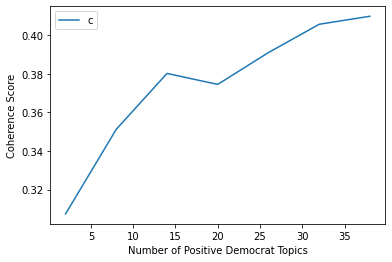

In [ ]:
def dem_pos_compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """Compute c_v score for a range of topics"""

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus=dem_pos_doc_term_matrix, id2word=dem_pos_dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=dem_pos_doc_clean, dictionary= dem_pos_dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values   

model_list, coherence_values = dem_pos_compute_coherence_values(dictionary= dem_pos_dictionary,corpus=dem_pos_doc_term_matrix,texts=dem_pos_doc_clean,start=2,limit=40,step=6)
import matplotlib.pyplot as plt
limit=40
start=2
step=6
x = range(start,limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Number of Positive Democrat Topics')
plt.ylabel('Coherence Score')
plt.legend(('coherence_values'),loc='best')
plt.show()

### Figure 8 Number of Optimal Topics for the positive democrat sentiment

10 Democrat topics positive in sentiment

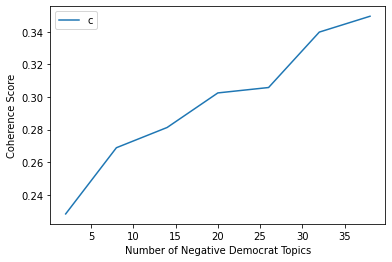

In [ ]:
def dem_neg_compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """Compute c_v score for a range of topics"""

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus=dem_neg_doc_term_matrix, id2word=dem_neg_dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=dem_neg_doc_clean, dictionary= dem_neg_dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values   

model_list, coherence_values = dem_neg_compute_coherence_values(dictionary= dem_neg_dictionary,corpus=dem_neg_doc_term_matrix,texts=dem_neg_doc_clean,start=2,limit=40,step=6)
import matplotlib.pyplot as plt
limit=40
start=2
step=6
x = range(start,limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Number of Negative Democrat Topics')
plt.ylabel('Coherence Score')
plt.legend(('coherence_values'),loc='best')
plt.show()

### Figure 9 Number of Optimal Topics for the negative democrat sentiment

15 Democrat topics negative in sentiment

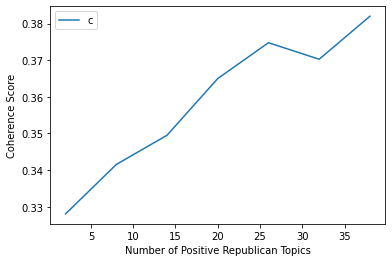

In [ ]:
def rep_pos_compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """Compute c_v score for a range of topics"""

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus=rep_pos_doc_term_matrix, id2word=rep_pos_dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=rep_pos_doc_clean, dictionary= rep_pos_dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values   

model_list, coherence_values = rep_pos_compute_coherence_values(dictionary= rep_pos_dictionary,corpus=rep_pos_doc_term_matrix,texts=rep_pos_doc_clean,start=2,limit=40,step=6)
import matplotlib.pyplot as plt
limit=40
start=2
step=6
x = range(start,limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Number of Positive Republican Topics')
plt.ylabel('Coherence Score')
plt.legend(('coherence_values'),loc='best')
plt.show()

### Figure 10 Number of Optimal Topics for the positive republican sentiment

 10 Republican topics positive in sentiment

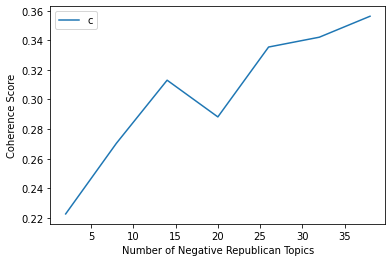

In [ ]:
def rep_neg_compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """Compute c_v score for a range of topics"""

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus=rep_neg_doc_term_matrix, id2word=rep_neg_dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=rep_neg_doc_clean, dictionary= rep_neg_dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values   

model_list, coherence_values = rep_neg_compute_coherence_values(dictionary= rep_neg_dictionary,corpus=rep_neg_doc_term_matrix,texts=rep_neg_doc_clean,start=2,limit=40,step=6)
import matplotlib.pyplot as plt
limit=40
start=2
step=6
x = range(start,limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Number of Negative Republican Topics')
plt.ylabel('Coherence Score')
plt.legend(('coherence_values'),loc='best')
plt.show()

### Figure 11 Number of Optimal Topics for the negative republican sentiment

15  Republican topics negative in sentiment

In [ ]:
dem_pos_ldamodel = LDA(dem_pos_doc_term_matrix, num_topics=10, id2word=dem_pos_dictionary, passes=30, random_state=123)
dem_neg_ldamodel = LDA(dem_neg_doc_term_matrix, num_topics=15, id2word=dem_neg_dictionary, passes=30, random_state=123)
rep_pos_ldamodel = LDA(rep_pos_doc_term_matrix, num_topics=10, id2word=rep_pos_dictionary, passes=30, random_state=123)
rep_neg_ldamodel = LDA(rep_neg_doc_term_matrix, num_topics=15, id2word=rep_neg_dictionary, passes=30, random_state=123)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim

ModuleNotFoundError: ignored

In [ ]:
dem_pos_vis = pyLDAvis.gensim.prepare(topic_model=dem_pos_ldamodel, corpus=dem_pos_doc_term_matrix,
                             dictionary=dem_pos_dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(dem_pos_vis)

### Figure 12 Topics found on the positive democrat sentiment

A lot of the words shown in the positive democrat tweets represent mostly support for Biden and his team. However, topic 9 has "fraud" as the most relevant term, while "Georgia" is the one for topic 10.

In [ ]:
dem_neg_vis = pyLDAvis.gensim.prepare(topic_model=dem_neg_ldamodel, corpus=dem_neg_doc_term_matrix,
                             dictionary=dem_neg_dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(dem_neg_vis)

### Figure 13 Topics found on the negative democrat sentiment

For the tweets found with negative sentiment, a lot of the topics focus on racism on black people. This is probably related to those who show deep opposition to the extremes of the republicans showing solidarity amongst the whites only. Covid was also part of the topics shown on the negative sentiment, indicating that despite being almost a year old, it still has impact on this quite large a scale.

In [ ]:
rep_pos_vis = pyLDAvis.gensim.prepare(topic_model=rep_pos_ldamodel, corpus=rep_pos_doc_term_matrix,
                             dictionary=rep_pos_dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(rep_pos_vis)

### Figure 14 Topics found on the positive republican sentiment

Republicans have a unique way of supporting their political party. Even though the sentiment is positive in nature, most relevant terms such as "recount" and "fraud" are the ones generated by the model. This indicates that they do not believe that the democrats have chances of winning this election and that there will be a possible recount should the results not be in their favor.

In [ ]:
rep_neg_vis = pyLDAvis.gensim.prepare(topic_model=rep_neg_ldamodel, corpus=rep_neg_doc_term_matrix,
                             dictionary=rep_neg_dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(rep_neg_vis)

### Figure 15 Topics found on the negative republican sentiment

For the negative republican tweets, the terms vary quite a lot from topic to topic. However, "black" and "racist" also appear here, possibly showing negative sentiments against people of color, since other words such as "million", "people" and "dead" also appear as frequent terms in the topics. In addition to that, #MAGA is relied on as their running sentiment to push through with supporting Trump, since another topic shown frequently here relates to the military where "freedom", "military", "veteran", and "losing" might mean that they do not wish to put the efforts of their military in vain simply because they have lost the elections.

In [ ]:
dem_tokens = dem.tokens
rep_tokens = rep.tokens

dem_gen_clean = [clean(file).split() for file in dem_tokens]
rep_gen_clean = [clean(file).split() for file in rep_tokens]

In [ ]:
dem_gen_dictionary = corpora.Dictionary(dem_gen_clean)
rep_gen_dictionary = corpora.Dictionary(rep_gen_clean)

dem_gen_term_matrix = [dem_gen_dictionary.doc2bow(tweet)
                      for tweet in dem_gen_clean]
rep_gen_term_matrix = [rep_gen_dictionary.doc2bow(tweet)
                      for tweet in rep_gen_clean]

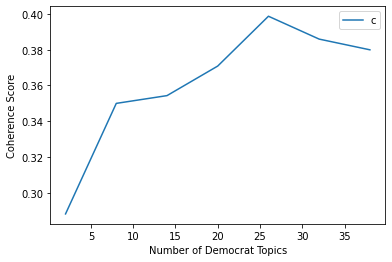

In [ ]:
def dem_gen_topic_coherence(dictionary, corpus, texts, limit, start=2, step=3):
    """Compute c_v score for a range of topics"""

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus=dem_gen_term_matrix, id2word=dem_gen_dictionary,
                    num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=dem_gen_clean,
                                        dictionary= dem_gen_dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values   

model_list, coherence_values = dem_pos_compute_coherence_values(
    dictionary= dem_gen_dictionary, corpus=dem_gen_term_matrix,
    texts=dem_gen_clean, start=2, limit=40, step=6)

import matplotlib.pyplot as plt
limit=40
start=2
step=6
x = range(start,limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Number of Democrat Topics')
plt.ylabel('Coherence Score')
plt.legend(('coherence_values'),loc='best')
plt.show()

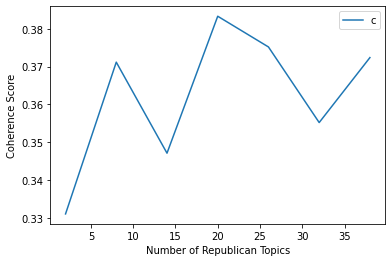

In [ ]:
def rep_gen_topic_coherence(dictionary, corpus, texts, limit, start=2, step=3):
    """Compute c_v score for a range of topics"""

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus=rep_gen_term_matrix, id2word=rep_gen_dictionary,
                    num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=rep_gen_clean,
                                        dictionary= rep_gen_dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values   

model_list, coherence_values = rep_pos_compute_coherence_values(
    dictionary= rep_gen_dictionary, corpus=rep_gen_term_matrix,
    texts=rep_gen_clean, start=2, limit=40, step=6)

import matplotlib.pyplot as plt
limit=40
start=2
step=6
x = range(start,limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Number of Republican Topics')
plt.ylabel('Coherence Score')
plt.legend(('coherence_values'),loc='best')
plt.show()

In [ ]:
dem_gen_ldamodel = LDA(dem_gen_term_matrix, num_topics=15,
                       id2word=dem_gen_dictionary, passes=30, random_state=123)
rep_gen_ldamodel = LDA(rep_gen_term_matrix, num_topics=10,
                       id2word=rep_gen_dictionary, passes=30, random_state=123)

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic,4),
                               topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution',
                              'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
dem_pos_topics = format_topics_sentences(ldamodel=dem_pos_ldamodel,
                                         corpus=dem_pos_doc_term_matrix,
                                         texts=dem_pos_doc_clean)
dem_neg_topics = format_topics_sentences(ldamodel=dem_neg_ldamodel,
                                         corpus=dem_neg_doc_term_matrix,
                                         texts=dem_neg_doc_clean)
rep_pos_topics = format_topics_sentences(ldamodel=rep_pos_ldamodel,
                                         corpus=rep_pos_doc_term_matrix,
                                         texts=rep_pos_doc_clean)
rep_neg_topics = format_topics_sentences(ldamodel=rep_neg_ldamodel,
                                         corpus=rep_neg_doc_term_matrix,
                                         texts=rep_neg_doc_clean)
rep_gen_topics = format_topics_sentences(ldamodel=rep_gen_ldamodel,
                                         corpus=rep_gen_term_matrix,
                                         texts=rep_gen_clean)
dem_gen_topics = format_topics_sentences(ldamodel=dem_gen_ldamodel,
                                         corpus=dem_gen_term_matrix,
                                         texts=dem_gen_clean)

df_dem_pos_dominant_topic = dem_pos_topics.reset_index()
df_dem_pos_dominant_topic.columns = ['Document_No', 'Dominant_Topic',
                                     'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dem_neg_dominant_topic = dem_neg_topics.reset_index()
df_dem_neg_dominant_topic.columns = ['Document_No', 'Dominant_Topic',
                                     'Topic_Perc_Contrib', 'Keywords', 'Text']
df_rep_pos_dominant_topic = rep_pos_topics.reset_index()
df_rep_pos_dominant_topic.columns = ['Document_No', 'Dominant_Topic',
                                     'Topic_Perc_Contrib', 'Keywords', 'Text']
df_rep_neg_dominant_topic = rep_neg_topics.reset_index()
df_rep_neg_dominant_topic.columns = ['Document_No', 'Dominant_Topic',
                                     'Topic_Perc_Contrib', 'Keywords', 'Text']
df_rep_gen_dominant_topic = rep_gen_topics.reset_index()
df_rep_gen_dominant_topic.columns = ['Document_No', 'Dominant_Topic',
                                     'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dem_gen_dominant_topic = dem_gen_topics.reset_index()
df_dem_gen_dominant_topic.columns = ['Document_No', 'Dominant_Topic',
                                     'Topic_Perc_Contrib', 'Keywords', 'Text']


df_dem_pos_dominant_topic.to_csv('dem_pos_topics.csv')
df_dem_neg_dominant_topic.to_csv('dem_neg_topics.csv')
df_rep_pos_dominant_topic.to_csv('rep_pos_topics.csv')
df_rep_neg_dominant_topic.to_csv('rep_neg_topics.csv')
df_rep_gen_dominant_topic.to_csv('rep_gen_topics.csv')
df_dem_gen_dominant_topic.to_csv('dem_gen_topics.csv')

all_topics = pd.concat([df_dem_pos_dominant_topic,df_dem_neg_dominant_topic,
                       df_rep_pos_dominant_topic,df_rep_neg_dominant_topic],
                      ignore_index=True)
all_topics.to_csv('all_topics.csv')

gen_all = pd.concat([df_rep_gen_dominant_topic, df_dem_gen_dominant_topic],
                    ignore_index=True)
gen_all.to_csv('all_gen.csv', index=False)


## Network Generation and Homophily Analysis

In [ ]:
rep.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest', 'clean_tweet', 'tokens', 'cluster', 'sentiment',
       'subject', 'polarity', 'party'],
      dtype='object')

In [ ]:
dem.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest', 'clean_tweet', 'tokens', 'cluster', 'sentiment',
       'subject', 'polarity', 'party'],
      dtype='object')

In [ ]:
print(dem.polarity.unique())
print(dem.subject.unique())
print(dem.cluster.unique())
print(dem.sentiment.unique())

['pos' 'neg']
[0.325      0.18333333 1.         ... 0.54464286 0.48968254 0.55627706]
[2 1 3 0]
[ 0.1         0.11666667  0.8        ...  0.41190476  0.15497835
 -0.14375   ]


In [ ]:
dem.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,clean_tweet,tokens,cluster,sentiment,subject,polarity,party
0,1326696150364286976,1326696150364286976,2020-11-12 01:19:45 UTC,2020-11-12,01:19:45,0,939091,joebiden,Joe Biden,NaN,"Ron Klain’s deep, varied experience and capaci...",en,[],[],[],9071.0,15903.0,189274.0,[],[],https://twitter.com/JoeBiden/status/1326696150...,False,https://twitter.com/transition46/status/132669...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,"Ron Klain’s deep, varied experience and capaci...",ron klain deep varied experience capacity work...,2,0.100000,0.325000,pos,democrat
1,1326638331204038656,1326638331204038656,2020-11-11 21:30:00 UTC,2020-11-11,21:30:00,0,939091,joebiden,Joe Biden,NaN,"This Veterans Day, I feel the full weight of t...",en,[],[],['https://pbs.twimg.com/media/EmkpBu_XUAE9Pp6....,8437.0,18763.0,271188.0,[],[],https://twitter.com/JoeBiden/status/1326638331...,False,NaN,1.0,https://pbs.twimg.com/media/EmkpBu_XUAE9Pp6.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,"This Veterans Day, I feel the full weight of t...",veterans day feel full weight honor responsibi...,2,0.116667,0.183333,pos,democrat
2,1326557341697839106,1326557341697839106,2020-11-11 16:08:11 UTC,2020-11-11,16:08:11,0,939091,joebiden,Joe Biden,NaN,"Today, we honor the service of those who have ...",en,[],[],[],8228.0,32069.0,351291.0,[],[],https://twitter.com/JoeBiden/status/1326557341...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,"Today, we honor the service of those who have ...",today honor service worn uniform armed forces ...,2,0.800000,1.000000,pos,democrat
3,1326344141446373376,1326344141446373376,2020-11-11 02:01:00 UTC,2020-11-11,02:01:00,0,939091,joebiden,Joe Biden,NaN,We are going to build a health care system tha...,en,[],[],[],17959.0,24186.0,420623.0,[],[],https://twitter.com/JoeBiden/status/1326344141...,False,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,We are going to build a health care system tha...,going build health care system puts family fir...,2,0.350000,0.444444,pos,democrat
4,1326325015290273792,1326325015290273792,2020-11-11 00:45:00 UTC,2020-11-11,00:45:00,0,939091,joebiden,Joe Biden,NaN,"If you’re sick, if you’re struggling, if you’r...",en,[],[],['https://pbs.twimg.com/media/EmgKztcXEAEhv1t....,7520.0,13977.0,186583.0,[],[],https://twitter.com/JoeBiden/status/1326325015...,False,NaN,1.0,https://pbs.twimg.com/media/EmgKztcXEAEhv1t.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,"If you’re sick, if you’re struggling, if you’r...",sick struggling worried going get day abandon ...,2,-0.714286,0.857143,neg,democrat


In [ ]:
print(len(dem.id.unique()))
print(len(dem.conversation_id.unique()))

22231
14007


In [ ]:
rep.mentions.unique()

array(['[]',
       "[{'screen_name': 'senjohnkennedy', 'name': 'john kennedy', 'id': '816683274076614656'}, {'screen_name': 'mariabartiromo', 'name': 'maria bartiromo', 'id': '208155240'}, {'screen_name': 'thejusticedept', 'name': 'justice department', 'id': '73181712'}]",
       "[{'screen_name': 'abc', 'name': 'abc news', 'id': '28785486'}, {'screen_name': 'washingtonpost', 'name': 'the washington post', 'id': '2467791'}]",
       ...,
       "[{'screen_name': 'gop', 'name': 'gop', 'id': '11134252'}, {'screen_name': 'rnc', 'name': 'rnc', 'id': '529648439'}, {'screen_name': 'potus', 'name': 'president trump', 'id': '822215679726100480'}]",
       "[{'screen_name': 'rodneydavis', 'name': 'us rep rodney davis', 'id': '993153006'}]",
       "[{'screen_name': 'parscale', 'name': 'brad parscale', 'id': '17685258'}]"],
      dtype=object)

# Homophily Tests
### Reloading from file

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/nlp_final

Mounted at /content/drive
/content/drive/MyDrive/nlp_final


In [4]:
dem = pd.read_csv('dem_expanded.csv')
rep = pd.read_csv('rep_expanded.csv')

df_dem_pos_dominant_topic = pd.read_csv('dem_pos_topics.csv')
df_dem_neg_dominant_topic = pd.read_csv('dem_neg_topics.csv')
df_rep_pos_dominant_topic = pd.read_csv('rep_pos_topics.csv')
df_rep_neg_dominant_topic = pd.read_csv('rep_neg_topics.csv')
df_rep_gen_dominant_topic = pd.read_csv('rep_gen_topics.csv')
df_dem_gen_dominant_topic = pd.read_csv('dem_gen_topics.csv')

all_topics = pd.read_csv('all_topics.csv')
gen_all_topics = pd.read_csv('all_gen.csv')

In [5]:
df_all = pd.concat([dem, rep])
print(df_all.columns)




Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest', 'clean_tweet', 'tokens', 'cluster', 'sentiment',
       'subject', 'polarity', 'party'],
      dtype='object')


In [ ]:
df_all['mentions'].apply(ast.literal_eval).iloc[-1][0]

{'id': '939091', 'name': 'joe biden', 'screen_name': 'joebiden'}

In [6]:
df_all.loc[:, 'mentions_name'] = df_all['mentions'].apply(ast.literal_eval)
df_all.loc[:, 'mentions_name'] = df_all['mentions_name'].apply(
    lambda x: [y['name'] for y in x if len(x)>0])

In [7]:
mentioned = list(set(df_all['mentions_name'].sum()))
users = df_all.name.unique().tolist()
all_users = list(set(users + mentioned))

## Tweet Mentions Network Graphs
### All Mentions

In [8]:
g_mentions = nx.DiGraph()
g_mentions.add_nodes_from(all_users)
# g_mentions.add_nodes_from(users)

In [9]:
df_mentions = df_all[['name', 'mentions_name']]

for ix, row in df_mentions.iterrows():
  if len(row['mentions_name']) > 0:
    for x in row['mentions_name']:
      g_mentions.add_edge(row['name'], x)

(-1.1937630146741867,
 1.2059677809476852,
 -1.190410214960575,
 1.2068144264817238)

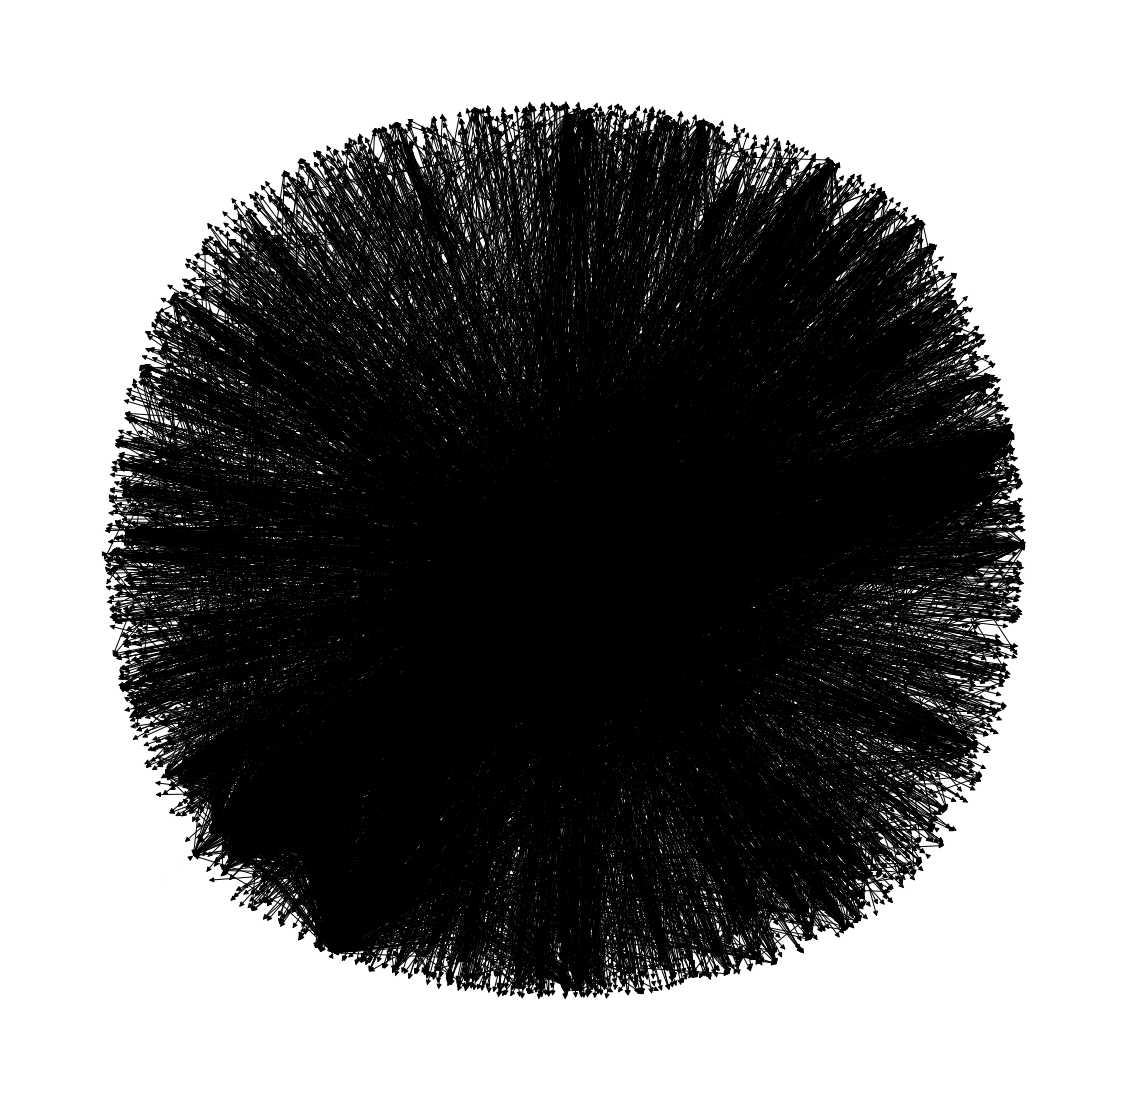

In [ ]:
pos = nx.spring_layout(g_mentions)
betCent = nx.betweenness_centrality(g_mentions, normalized=True, endpoints=True)
node_color = [20000.0 * g_mentions.degree(v) for v in g_mentions]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(g_mentions, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

In [ ]:
sorted(betCent, key=betCent.get, reverse=True)[:10]

['donald j. trump',
 'joe biden',
 'youtube',
 'kamala harris',
 'team joe (text joe to 30330)',
 'gop',
 '60 minutes',
 'president trump',
 'jim hoft',
 'the lincoln project']

### Democrat Mentions

In [10]:
g_dem_mentions = nx.DiGraph()

df_dem_mentions = df_all.loc[df_all.party=='democrat',
                             ['name', 'mentions_name']]
g_dem_mentions.add_nodes_from(df_dem_mentions.name.unique().tolist())

for ix, row in df_dem_mentions.iterrows():
  if len(row['mentions_name']) > 0:
    for x in row['mentions_name']:
      g_dem_mentions.add_edge(row['name'], x)

In [ ]:
pos = nx.spring_layout(g_dem_mentions)
betCent = nx.betweenness_centrality(g_dem_mentions, normalized=True,
                                    endpoints=True)
node_color = [20000.0 * g_dem_mentions.degree(v) for v in g_dem_mentions]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(50,50))
nx.draw_networkx(g_dem_mentions, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

In [ ]:
sorted(betCent, key=betCent.get, reverse=True)[:10]

### Republican Mentions

In [11]:
g_rep_mentions = nx.DiGraph()

df_rep_mentions = df_all.loc[df_all.party=='republican',
                             ['name', 'mentions_name']]
g_rep_mentions.add_nodes_from(df_rep_mentions.name.unique().tolist())

for ix, row in df_rep_mentions.iterrows():
  if len(row['mentions_name']) > 0:
    for x in row['mentions_name']:
      g_rep_mentions.add_edge(row['name'], x)

(-1.2073705133795738,
 1.1859276828169822,
 -1.1903633522987367,
 1.1983693289756776)

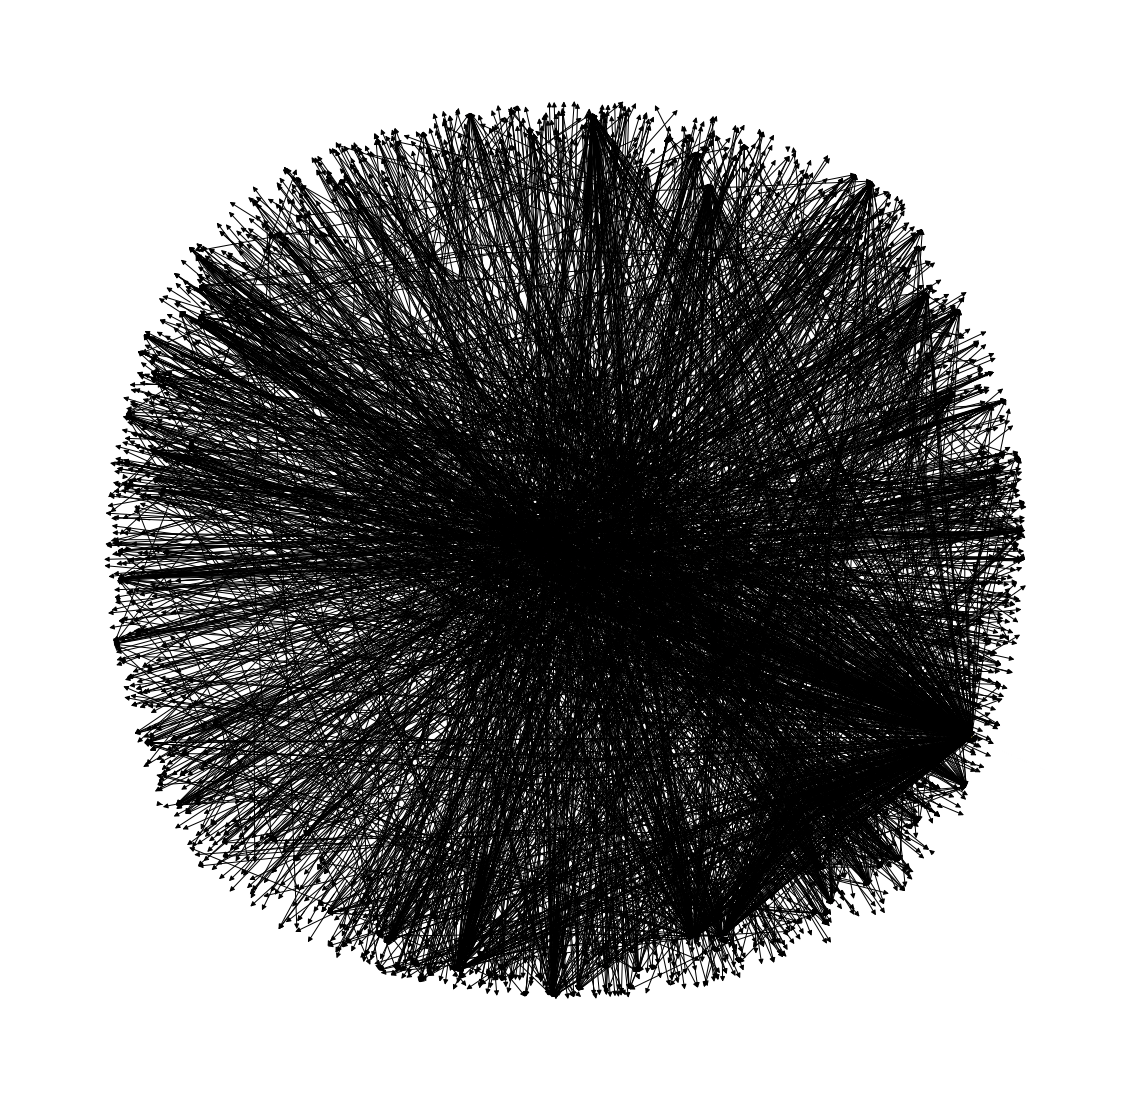

In [ ]:
pos = nx.spring_layout(g_rep_mentions)
betCent = nx.betweenness_centrality(g_rep_mentions, normalized=True,
                                    endpoints=True)
node_color = [30000.0 * g_rep_mentions.degree(v) for v in g_rep_mentions]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(g_rep_mentions, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

In [ ]:
sorted(betCent, key=betCent.get, reverse=True)[:10]

['donald j. trump',
 'joe biden',
 'youtube',
 '60 minutes',
 'gop',
 'president trump',
 'jim hoft',
 'Donald J. Trump',
 'vice president mike pence',
 'donald trump jr.']

In [ ]:
import pickle

with open('networks.pkl', 'wb') as f:
  pickle.dump({'all': g_mentions,
               'dem': g_dem_mentions,
               'rep': g_rep_mentions}, f)

## Homophily Tests
1. Homophily of political party
  - (g_mentions, df_all['party'])
2. Homophily of similar sentiment within a political affiliation
  - (g_dem_mentions, dem['polarity'])
  - (g_rep_mentions, rep['polarity'])
3. Homophily of similar sentiment regardless of political affiliation
  - (g_mentions, df_all['polarity'])
4. Homophily of hashtags within a political affiliation
  - (g_dem_mentions, dem['hashtags'])
  - (g_rep_mentions, rep['hashtags'])
5. Homophily of topics within a political affiliation
  - (g_dem_mentions, dem_gen['topics'])
  - (g_rep_mentions, rep_gen['topics'])
6. Homophily of topics within a sentimental+political alignment
  - (g_dem_mentions, df_dem_pos['topics'])
  - (g_dem_mentions, df_dem_neg['topics'])
  - (g_rep_mentions, df_rep_pos['topics'])
  - (g_rep_mentions, df_rep_neg['topics'])

In [12]:
from collections import Counter
def frequency(chars):
    return {x: y / len(chars.values())
            for x, y in Counter(chars.values()).items()}
    
    
def chance_homophily(chars):
    return sum([y**2 for y in frequency(chars).values()])

def homophily_names(G, chars):
    """
    Given a network G, a dict of characteristics chars for node IDs,
    and dict of node IDs for each node in the network,
    find the homophily of the network.
    """
    num_same_ties = 0
    num_ties = 0
    for n1, n2 in G.edges():
        if n1 in chars.keys() and n2 in chars.keys():
            if G.has_edge(n1, n2):
                # num_same_ties += 1
                num_ties = 1
                if chars[n1] == chars[n2]:
                    # num_ties += 1
                    num_same_ties += 1
    return (num_same_ties / num_ties)

def homophily_ht(G, chars):
    """
    Given a network G, a dict of characteristics chars for node IDs,
    and dict of node IDs for each node in the network,
    find the homophily of the network.
    """
    num_same_ties = 0
    num_ties = 0
    
    for n1, n2 in G.edges():
        if n1 in chars and n2 in chars:
            if G.has_edge(n1, n2):
                # num_same_ties += 1
                num_ties = 1
                ht_intersect = len(set(chars[n1]).intersection(set(chars[n2])))
                # print(set(chars[n1]).intersection(set(chars[n2])))
                # ht_union = len(set(chars[n1]).union(set(chars[n2])))
                # print(set(chars[n1]).union(set(chars[n2])))
                if ht_intersect > 0:
                    # num_ties += 1
                    num_same_ties += 1
    return (num_same_ties / num_ties)    

def homophily_ids(G, chars, IDs):
    """
    Given a network G, a dict of characteristics chars for node IDs,
    and dict of node IDs for each node in the network,
    find the homophily of the network.
    """
    num_same_ties = 0
    num_ties = 0
    for n1, n2 in G.edges():
      if n2 in IDs.keys():
        if set(IDs[n1]).intersection(set(IDs[n2])) != []:
          if G.has_edge(n1, n2):
            # num_same_ties += 1
            num_ties += 1
            if chars[IDs[n1]] == chars[IDs[n2]]:
                # num_ties += 1
                num_same_ties += 1
    return (num_same_ties / num_ties)    

def inbreeding_homophily(H, chars):
  w = chance_homophily(chars)
  return (H-w) / (1-w)

In [13]:
ids_dem = dem.groupby('name').id.agg(list).reset_index().to_numpy()
ids_dem = {x: y for x, y in ids_dem}
ids_rep = rep.groupby('name').id.agg(list).reset_index().to_numpy()
ids_rep = {x: y for x, y in ids_rep}

### Homophily of Party Affiliation

In [14]:
# 1. Political Party
df_all_partylist = df_all[['name','party']].drop_duplicates()

partylist = {x: y for x, y in zip(df_all_partylist['name'],
                                  df_all_partylist['party'])}

H = homophily_names(g_mentions, partylist)
iH = inbreeding_homophily(H, partylist)

print('Partylist Homophily: ', H)
print('Partylist Inbreeding Homophily: ', iH)

Partylist Homophily:  36.0
Partylist Inbreeding Homophily:  76.69778056449353


### Homophily of Dominant Sentiment within a Party

In [15]:
# 2. Political Polarity
df_dem_polarity = dem[['name', 'polarity']].drop_duplicates()
df_dem_polarity = df_dem_polarity.groupby('name').agg(
    lambda x:x.value_counts().index[0]).reset_index()
dem_polarity = {x: y for x, y in zip(df_dem_polarity['name'],
                                     df_dem_polarity['polarity'])}

H = homophily_names(g_dem_mentions, dem_polarity)
iH = inbreeding_homophily(H, dem_polarity)

print('Democrat Sentiment Homophily: ', H)
print('Democrat Sentiment Inbreeding Homophily: ', iH)

df_rep_polarity = rep[['name', 'polarity']].drop_duplicates()
df_rep_polarity = df_rep_polarity.groupby('name').agg(
    lambda x:x.value_counts().index[0]).reset_index()
rep_polarity = {x: y for x, y in zip(df_rep_polarity['name'],
                                     df_rep_polarity['polarity'])}

H = homophily_names(g_rep_mentions, rep_polarity)
iH = inbreeding_homophily(H, rep_polarity)

print('Republican Sentiment Homophily: ', H)
print('Republican Sentiment Inbreeding Homophily: ', iH)

Democrat Sentiment Homophily:  13.0
Democrat Sentiment Inbreeding Homophily:  33.11417540951304
Republican Sentiment Homophily:  20.0
Republican Sentiment Inbreeding Homophily:  50.160347846550586


### Homophily of Dominant Sentiment Regardless of Party

In [16]:
# 3. Polarity
df_all_polarity = df_all[['name','polarity']].drop_duplicates()
df_all_polarity = df_all_polarity.groupby('name').agg(
    lambda x:x.value_counts().index[0]).reset_index()

polarity = {x: y for x, y in zip(df_all_polarity['name'],
                                  df_all_polarity['polarity'])}

H = homophily_names(g_mentions, polarity)
iH = inbreeding_homophily(H, polarity)

print('Sentiment Homophily: ', H)
print('Sentiment Inbreeding Homophily: ', iH)

Sentiment Homophily:  34.0
Sentiment Inbreeding Homophily:  86.28525248629965


### Homophily of Hashtags within a Party

In [ ]:
# df_dem_hashtags = dem[['name', 'hashtags']].drop_duplicates().dropna()
# df_dem_hashtags['hashtags'] = df_dem_hashtags.hashtags.apply(ast.literal_eval)
# df_dem_hashtags = df_dem_hashtags.groupby('name').agg(lambda x: tuple(x.sum())).reset_index()
df_dem_hashtags.loc[(df_dem_hashtags['hashtags']!=()) & df_dem_hashtags['name'].isin(mentioned)].name.unique().shape

(4,)

In [17]:
# 4. Political Hashtags
df_dem_hashtags = dem[['name', 'hashtags']].drop_duplicates().dropna()
df_dem_hashtags['hashtags'] = df_dem_hashtags.hashtags.apply(ast.literal_eval)
df_dem_hashtags = df_dem_hashtags.groupby('name').agg(sum).reset_index()
dem_hashtags = {x: tuple(y) for x, y in zip(df_dem_hashtags['name'],
                                     df_dem_hashtags['hashtags'])}

H = homophily_ht(g_dem_mentions, dem_hashtags)
iH = inbreeding_homophily(H, dem_hashtags)

print('Democrat Hashtag Homophily: ', H)
print('Democrat Hashtag Inbreeding Homophily: ', iH)

df_rep_hashtags = rep[['name', 'hashtags']].drop_duplicates().dropna()
df_rep_hashtags['hashtags'] = df_rep_hashtags.hashtags.apply(ast.literal_eval)
df_rep_hashtags = df_rep_hashtags.groupby('name').agg(sum).reset_index()
rep_hashtags = {x: tuple(y) for x, y in zip(df_rep_hashtags['name'],
                                     df_rep_hashtags['hashtags'])}

H = homophily_ht(g_rep_mentions, rep_hashtags)
iH = inbreeding_homophily(H, rep_hashtags)

print('Republican Hashtag Homophily: ', H)
print('Republican Hashtag Inbreeding Homophily: ', iH)

Democrat Hashtag Homophily:  0.0
Democrat Hashtag Inbreeding Homophily:  -1.647239094058979
Republican Hashtag Homophily:  3.0
Republican Hashtag Inbreeding Homophily:  5.566990131170059


### Homophily of Tweet Dominant Topic within a Party Regardless of Sentiment

In [19]:
print('Republican Topic Sample')
display(df_rep_gen_dominant_topic.head())
print(df_rep_gen_dominant_topic.shape)
print(rep.shape)

print('Democrat Topics Sample')
display(df_dem_gen_dominant_topic.head())
print(df_dem_gen_dominant_topic.shape)
print(dem.shape)

Republican Topic Sample


,Unnamed: 0,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,7.0,0.5500,"trump, vote, maga, today, yes, via, video, mr,...",['vote']
1,1,1,4.0,0.3541,"maga, like, trump, republican, one, voted, thi...","['ok', 'seen', 'enough', 'going', 'happen', 'g..."
2,2,2,7.0,0.8336,"trump, vote, maga, today, yes, via, video, mr,...","['vote', 'le', 'vote', 'audit', 'total', 'vote..."
3,3,3,9.0,0.4882,"trump, support, president, maga, donald, peopl...","['big', 'jim', 'greatest']"
4,4,4,0.0,0.5372,"republican, trump, vote, biden, people, year, ...","['took', 'long', 'enough', 'taking', 'north', ..."


(32344, 6)
(32344, 43)
Democrat Topics Sample


,Unnamed: 0,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,4.0,0.3468,"vote, blue, texas, go, please, need, america, ...","['ron', 'klain', 'deep', 'varied', 'experience..."
1,1,1,0.0,0.5542,"biden, joe, sign, event, join, president, atte...","['veteran', 'day', 'feel', 'full', 'weight', '..."
2,2,2,11.0,0.3926,"amp, trump, good, people, plan, american, amer...","['today', 'honor', 'service', 'worn', 'uniform..."
3,3,3,10.0,0.6783,"biden, trump, love, people, tax, right, care, ...","['going', 'build', 'health', 'care', 'system',..."
4,4,4,14.0,0.3274,"democrat, get, time, let, day, u, need, back, ...","['sick', 'struggling', 'worried', 'going', 'ge..."


(22808, 6)
(22808, 43)


In [20]:
rep_merged = rep.join(df_rep_gen_dominant_topic)
dem_merged = dem.join(df_dem_gen_dominant_topic)

In [ ]:
# 5. Party Topics

df_dem_topics = dem_merged[['name', 'Dominant_Topic']].drop_duplicates()
df_dem_topics = df_dem_topics.groupby('name').agg(
    list).reset_index()
dem_topics = {x: tuple(y) for x, y in zip(df_dem_topics['name'],
                                     df_dem_topics['Dominant_Topic'])}

H = homophily_ht(g_dem_mentions, dem_topics)
iH = inbreeding_homophily(H, dem_topics)

print('Democrat Topic Homophily: ', H)
print('Democrat Topic Inbreeding Homophily: ', iH)

df_rep_topics = rep_merged[['name', 'Dominant_Topic']].drop_duplicates()
df_rep_topics = df_rep_topics.groupby('name').agg(
    list).reset_index()
rep_topics = {x: tuple(y) for x, y in zip(df_rep_topics['name'],
                                     df_rep_topics['Dominant_Topic'])}

H = homophily_ht(g_rep_mentions, rep_topics)
iH = inbreeding_homophily(H, rep_topics)

print('Republican Topic Homophily: ', H)
print('Republican Topic Inbreeding Homophily: ', iH)

Democrat Topic Homophily:  7.0
Democrat Topic Inbreeding Homophily:  7.3525383659340715
Republican Topic Homophily:  11.0
Republican Topic Inbreeding Homophily:  13.266819733986972


### Homophily of Sentiment-Aligned Tweet Dominant Topic within a Party

In [21]:
rep_pos_merged = rep[rep['polarity']=='pos'].join(df_rep_pos_dominant_topic)
rep_neg_merged = rep[rep['polarity']=='neg'].join(df_rep_neg_dominant_topic)
dem_pos_merged = dem[dem['polarity']=='pos'].join(df_dem_pos_dominant_topic)
dem_neg_merged = dem[dem['polarity']=='neg'].join(df_dem_neg_dominant_topic)

In [23]:
df_dem_pos_topics = dem_pos_merged[['name', 'Dominant_Topic']].drop_duplicates()
df_dem_pos_topics = df_dem_pos_topics.groupby('name').agg(
    list).reset_index()
df_dem_pos_topics.sample(10)

,name,Dominant_Topic
4083,J S,[nan]
3029,Emma Anyika,[nan]
1017,Best pumpkin Tsukky 🎃🎃🎃,[3.0]
11491,ray ✿ you changed me dean,[5.0]
2131,DARYL KOONCE,[nan]
1887,Clandestine A.I. Operative,[nan]
7619,President-Elect StuccoHouse,"[4.0, 1.0, 2.0]"
7682,Psiborg_Jhin.exe⚙️,[4.0]
1062,"Biden won! Wait, now what?! 🎨",[4.0]
9391,The Spectator US,[9.0]


In [90]:
# 6. Sentiment-aligned Party Topics

df_dem_pos_topics = dem_pos_merged[['name', 'Dominant_Topic']].drop_duplicates()
df_dem_pos_topics = df_dem_pos_topics.groupby('name').agg(
    list).reset_index()
dem_pos_topics = {x: tuple(y) for x, y in zip(df_dem_pos_topics['name'],
                                     df_dem_pos_topics['Dominant_Topic'])}

H = homophily_ht(g_dem_mentions, dem_pos_topics)
iH = inbreeding_homophily(H, dem_pos_topics)

print('Positive Democrat Topic Homophily: ', H)
print('Positive Democrat Topic Inbreeding Homophily: ', iH)

df_dem_neg_topics = dem_neg_merged[['name', 'Dominant_Topic']].drop_duplicates()
df_dem_neg_topics = df_dem_neg_topics.groupby('name').agg(
    list).reset_index()
dem_neg_topics = {x: tuple(y) for x, y in zip(df_dem_neg_topics['name'],
                                     df_dem_neg_topics['Dominant_Topic'])}

H = homophily_ht(g_dem_mentions, dem_neg_topics)
iH = inbreeding_homophily(H, dem_neg_topics)

print('Negative Democrat Topic Homophily: ', H)
print('Negative Democrat Topic Inbreeding Homophily: ', iH)

Positive Democrat Topic Homophily:  4.0
Positive Democrat Topic Inbreeding Homophily:  4.196733270588627
Negative Democrat Topic Homophily:  0.0
Negative Democrat Topic Inbreeding Homophily:  -0.0010142503181790959


In [24]:
df_rep_pos_topics = rep_pos_merged[['name', 'Dominant_Topic']].drop_duplicates()
df_rep_pos_topics = df_rep_pos_topics.groupby('name').agg(
    list).reset_index()
rep_pos_topics = {x: tuple(y) for x, y in zip(df_rep_pos_topics['name'],
                                     df_rep_pos_topics['Dominant_Topic'])}

H = homophily_ht(g_rep_mentions, rep_pos_topics)
iH = inbreeding_homophily(H, rep_pos_topics)

print('Positive Republican Topic Homophily: ', H)
print('Positive Republican Topic Inbreeding Homophily: ', iH)

df_rep_neg_topics = rep_neg_merged[['name', 'Dominant_Topic']].drop_duplicates()
df_rep_neg_topics = df_rep_neg_topics.groupby('name').agg(
    list).reset_index()
rep_neg_topics = {x: tuple(y) for x, y in zip(df_rep_neg_topics['name'],
                                     df_rep_neg_topics['Dominant_Topic'])}

H = homophily_ht(g_rep_mentions, rep_neg_topics)
iH = inbreeding_homophily(H, rep_neg_topics)

print('Negative Republican Topic Homophily: ', H)
print('Negative Republican Topic Inbreeding Homophily: ', iH)

Positive Republican Topic Homophily:  4.0
Positive Republican Topic Inbreeding Homophily:  4.2009530302495
Negative Republican Topic Homophily:  0.0
Negative Republican Topic Inbreeding Homophily:  -0.003699872729853113


## ANNEX: Additional "Homophily" Tests for Hashtags and Topics

Rather than actual homophily calculations, these tests explore actual usage (general prevalence of certain topics and hashtags)

In [25]:
def homophily_ht2(G, chars):
    """
    Given a network G, a dict of characteristics chars for node IDs,
    and dict of node IDs for each node in the network,
    find the homophily of the network.
    """
    num_same_ties = 0
    num_ties = 0
    
    for n1, n2 in G.edges():
        if n1 in chars and n2 in chars:
            if G.has_edge(n1, n2):
                # num_same_ties += 1
                num_ties = 1
                ht_intersect = len(set(chars[n1]).intersection(set(chars[n2])))
                # print(set(chars[n1]).intersection(set(chars[n2])))
                ht_union = len(set(chars[n1]).union(set(chars[n2])))
                # print(set(chars[n1]).union(set(chars[n2])))
                if ht_union > 0:
                    # num_ties += 1
                    num_same_ties += 1
    return (num_same_ties / num_ties)

### Hashtag Use Density within a Party

In [26]:
# Annex_1. Political Hashtag Density
df_dem_hashtags = dem[['name', 'hashtags']].drop_duplicates().dropna()
df_dem_hashtags['hashtags'] = df_dem_hashtags.hashtags.apply(ast.literal_eval)
df_dem_hashtags = df_dem_hashtags.groupby('name').agg(sum).reset_index()
dem_hashtags = {x: tuple(y) for x, y in zip(df_dem_hashtags['name'],
                                     df_dem_hashtags['hashtags'])}

H = homophily_ht2(g_dem_mentions, dem_hashtags)
iH = inbreeding_homophily(H, dem_hashtags)

print('Democrat Hashtag Homophily: ', H)
print('Democrat Hashtag Inbreeding Homophily: ', iH)

df_rep_hashtags = rep[['name', 'hashtags']].drop_duplicates().dropna()
df_rep_hashtags['hashtags'] = df_rep_hashtags.hashtags.apply(ast.literal_eval)
df_rep_hashtags = df_rep_hashtags.groupby('name').agg(sum).reset_index()
rep_hashtags = {x: tuple(y) for x, y in zip(df_rep_hashtags['name'],
                                     df_rep_hashtags['hashtags'])}

H = homophily_ht2(g_rep_mentions, rep_hashtags)
iH = inbreeding_homophily(H, rep_hashtags)

print('Republican Hashtag Homophily: ', H)
print('Republican Hashtag Inbreeding Homophily: ', iH)

Democrat Hashtag Homophily:  12.0
Democrat Hashtag Inbreeding Homophily:  30.119630034648768
Republican Hashtag Homophily:  14.0
Republican Hashtag Inbreeding Homophily:  30.685435852605384


### Topics Prevalence within a Party Regardless of Sentiment

In [27]:
# Annex_2. Party Topics Density
df_dem_topics = dem_merged[['name', 'Dominant_Topic']].drop_duplicates()
df_dem_topics = df_dem_topics.groupby('name').agg(
    list).reset_index()
dem_topics = {x: tuple(y) for x, y in zip(df_dem_topics['name'],
                                     df_dem_topics['Dominant_Topic'])}

H = homophily_ht2(g_dem_mentions, dem_topics)
iH = inbreeding_homophily(H, dem_topics)

print('Democrat Topic Homophily: ', H)
print('Democrat Topic Inbreeding Homophily: ', iH)

df_rep_topics = rep_merged[['name', 'Dominant_Topic']].drop_duplicates()
df_rep_topics = df_rep_topics.groupby('name').agg(
    list).reset_index()
rep_topics = {x: tuple(y) for x, y in zip(df_rep_topics['name'],
                                     df_rep_topics['Dominant_Topic'])}

H = homophily_ht2(g_rep_mentions, rep_topics)
iH = inbreeding_homophily(H, rep_topics)

print('Republican Topic Homophily: ', H)
print('Republican Topic Inbreeding Homophily: ', iH)

Democrat Topic Homophily:  17.0
Democrat Topic Inbreeding Homophily:  17.940102309157524
Republican Topic Homophily:  24.0
Republican Topic Inbreeding Homophily:  29.213685388170035


### Sentiment-aligned Topics Prevalence in a Party

In [28]:
# Annex_3. Sentiment-aligned Party Topics

df_dem_pos_topics = dem_pos_merged[['name', 'Dominant_Topic']].drop_duplicates()
df_dem_pos_topics = df_dem_pos_topics.groupby('name').agg(
    list).reset_index()
dem_pos_topics = {x: tuple(y) for x, y in zip(df_dem_pos_topics['name'],
                                     df_dem_pos_topics['Dominant_Topic'])}

H = homophily_ht2(g_dem_mentions, dem_pos_topics)
iH = inbreeding_homophily(H, dem_pos_topics)

print('Positive Democrat Topic Homophily: ', H)
print('Positive Democrat Topic Inbreeding Homophily: ', iH)

df_dem_neg_topics = dem_neg_merged[['name', 'Dominant_Topic']].drop_duplicates()
df_dem_neg_topics = df_dem_neg_topics.groupby('name').agg(
    list).reset_index()
dem_neg_topics = {x: tuple(y) for x, y in zip(df_dem_neg_topics['name'],
                                     df_dem_neg_topics['Dominant_Topic'])}

H = homophily_ht2(g_dem_mentions, dem_neg_topics)
iH = inbreeding_homophily(H, dem_neg_topics)

print('Negative Democrat Topic Homophily: ', H)
print('Negative Democrat Topic Inbreeding Homophily: ', iH)

Positive Democrat Topic Homophily:  16.0
Positive Democrat Topic Inbreeding Homophily:  16.983666352943132
Negative Democrat Topic Homophily:  1.0
Negative Democrat Topic Inbreeding Homophily:  1.0


In [29]:
df_rep_pos_topics = rep_pos_merged[['name', 'Dominant_Topic']].drop_duplicates()
df_rep_pos_topics = df_rep_pos_topics.groupby('name').agg(
    list).reset_index()
rep_pos_topics = {x: tuple(y) for x, y in zip(df_rep_pos_topics['name'],
                                     df_rep_pos_topics['Dominant_Topic'])}

H = homophily_ht2(g_rep_mentions, rep_pos_topics)
iH = inbreeding_homophily(H, rep_pos_topics)

print('Positive Republican Topic Homophily: ', H)
print('Positive Republican Topic Inbreeding Homophily: ', iH)

df_rep_neg_topics = rep_neg_merged[['name', 'Dominant_Topic']].drop_duplicates()
df_rep_neg_topics = df_rep_neg_topics.groupby('name').agg(
    list).reset_index()
rep_neg_topics = {x: tuple(y) for x, y in zip(df_rep_neg_topics['name'],
                                     df_rep_neg_topics['Dominant_Topic'])}

H = homophily_ht2(g_rep_mentions, rep_neg_topics)
iH = inbreeding_homophily(H, rep_neg_topics)

print('Negative Republican Topic Homophily: ', H)
print('Negative Republican Topic Inbreeding Homophily: ', iH)

Positive Republican Topic Homophily:  21.0
Positive Republican Topic Inbreeding Homophily:  22.339686868330002
Negative Republican Topic Homophily:  4.0
Negative Republican Topic Inbreeding Homophily:  4.011099618189559
